In [1]:
import os
import itertools

try: 
    import numpy as np
except:
    ! pip install numpy
    import numpy as np
    
try: 
    import pandas as pd
except:
    ! pip install pandas
    import pandas as pd
    
try: 
    import sklearn
except:
    ! pip install sklearn

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.model_selection import train_test_split

try: 
    import nltk
except:
    ! pip install nltk
    import nltk    
## Download Resources
nltk.download('punkt')
nltk.download('words')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download("stopwords")
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.corpus import words, stopwords
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

############
try: 
    import syllables
except:
    ! pip install syllables
    import syllables

import string

try: 
    import scipy
except:
    ! pip install scipy
from scipy.sparse import coo_matrix, hstack

import warnings
warnings.filterwarnings('ignore')

#import pickle

try: 
    import matplotlib
except:
    ! pip install matplotlib
    
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /Users/pingwu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /Users/pingwu/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/pingwu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/pingwu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pingwu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
def appendArticles(articleList, basePath):
    # This function appends all the support articles into one. 
    contents = ''
    for articleNumber in articleList:
        f = open(basePath+str(articleNumber)+".txt", "r", encoding="utf8")
        contents = f.read()+";"+contents
        f.close()
    return contents

def stemTweetToWordList(text, stopWords):
    # This function lower all the words in the text, then 
    # exclude the stop words and stem the rest.
    ps = PorterStemmer()
    tweet =text.lower() # lower case
    tokenizer = RegexpTokenizer(r'\w+')  
    wordList = tokenizer.tokenize(tweet)
     # remove stop words and store the stem version. 
    return [ps.stem(word) for word in wordList if word not in stopWords]

def startNumber(text):
    # This function check if the claim start with numbers.
    if text[:1].isdigit():
        return 1
    else:
        return 0

def containQuestion(text):
    # This function check if the claim has particular punctuations.
    if '?' in text or '!' in text:
        return 1
    else:
        return 0
    
def numberSyllable(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    number_words = len(text.split())
    total = 0
    for word in text.split():
        total += syllables.estimate(word)
    return total/number_words

def assignLength(row, colName):
    # This function returns the length of the text
    return len(row[colName])

def POSTagging(text):
    # This function assigns part of speech tag to words
    tokens = nltk.word_tokenize(text)
    return nltk.pos_tag(tokens) 

def adjectives(lists):
    # This function counts the number of adjective words.
    count = 0
    adjective_tag = ['JJ','JJR','JJS']
    for word in lists:
        if word[1] in adjective_tag:
            count +=1
    return count

def nouns(lists):
    # This function counts the number of noun words.
    count = 0
    noun_tag = ['NN','NNS','NNP']
    for word in lists:
        if word[1] in noun_tag:
            count +=1
    return count

def verbs(lists):
    # This function counts the number of verb words.
    count = 0
    verb_tag = ['VB','VBD','VBG','VBN','VBP','VBZ']
    for word in lists:
        if word[1] in verb_tag:
            count +=1
    return count

def firstWord(lists):
    # This function checks if the first word is in the below category.
    tag = ['VB','VBD','VBG','VBN','VBP','VBZ','NN','NNS','NNP','JJ','JJR','JJS']
    word = lists[0]
    if word in tag:
        return 1
    else:
        return 0
    
def lastWord(lists):
    # This function checks if the last word is in the below category.
    tag = ['VB','VBD','VBG','VBN','VBP','VBZ','NN','NNS','NNP','JJ','JJR','JJS']
    word = lists[-1]
    if word in tag:
        return 1
    else:
        return 0
    
def FPP(lists):
    # This function counts the number of first person words.
    count = 0
    FPP_tag = ['I','ME','WE','US','MY','MINE','OUR','OURS']
    for word in lists:
        if word[0].upper() in FPP_tag:
            count +=1
    return count

In [3]:
# read the data from local files
basePath = os.getcwd()
# 0:false, 1:partly true, 2:true
claim = pd.read_json(open(basePath + "/train.json", "r", encoding="utf8"))
txtPath = basePath+"/articles/"

In [ ]:
# combine all support articles into one for data cleaning purpose
claim['articleTextRaw'] = claim.apply(lambda row: appendArticles(row['related_articles'], txtPath) ,axis=1)
# process the article text including lower words, exclude stop words and stem them.
stopWords = stopwords.words('english')
claim['articleText'] = claim.apply(lambda row: stemTweetToWordList(row['articleTextRaw'], stopWords) ,axis=1)

In [7]:
# use nltk sentiment analyzer to analyze the sentiment of claims, and get a score in between -1 and 1.
sid = SentimentIntensityAnalyzer()
claim['claimSentiment'] = claim.apply(lambda row: sid.polarity_scores(row['claim'])['compound'] ,axis=1)
claim['SentimentAdjust'] = claim['claimSentiment']+1

In [8]:
#check if claim starts with a number
claim['start_number'] = claim.apply(lambda row: startNumber(row['claim']) ,axis=1)

In [9]:
#check if claim contain any ? or !
claim['containQX'] = claim.apply(lambda row: containQuestion(row['claim']) ,axis=1)
#number of words in the claim
claim['titleWords'] = claim.apply(lambda row: len(row['claim'].split()) ,axis=1)
#number of related articles to the claim
claim['numberArticle'] = claim.apply(lambda row: len(row['related_articles']) ,axis=1)
#number of average syllables in each word in the claim
claim['claimSyllable'] = claim.apply(lambda row: numberSyllable(row['claim']) ,axis=1)
claim['articleLength'] = claim.apply(lambda row: assignLength(row, 'articleText'), axis=1)
count = lambda l1,l2: sum([1 for x in l1 if x in l2])
#get number of punctuation in the claim
claim['claimPunc'] = claim.apply(lambda row: count(row['claim'],set(string.punctuation)), axis=1)
#get number of punctuation in each related articles
claim['articlePunc'] = claim.apply(lambda row: count(row['articleText'],set(string.punctuation))/row['numberArticle'], axis=1)


In [10]:
#get a list of words and their POS for the claim
claim['claimPOS'] = claim.apply(lambda row: POSTagging(row['claim']), axis=1)
#check number of adjectives, nouns, and verbs in the claim
claim['claimAdj'] = claim.apply(lambda row: adjectives(row['claimPOS']), axis=1)
claim['claimNoun'] = claim.apply(lambda row: nouns(row['claimPOS']), axis=1)
claim['claimVerb'] = claim.apply(lambda row: verbs(row['claimPOS']), axis=1)
claim['claimPOSratio'] = claim.apply(lambda row: (row['claimAdj']+row['claimNoun']+row['claimVerb'])/len(row['claimPOS']), axis=1)
claim['claimFirst'] = claim.apply(lambda row: firstWord(row['claimPOS']), axis=1)
claim['claimLast'] = claim.apply(lambda row: lastWord(row['claimPOS']), axis=1)
claim['claimFPP'] = claim.apply(lambda row: FPP(row['claimPOS']), axis=1)

In [3]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.tight_layout()
    plt.show()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    #plt.yticks(tick_marks, classes)
    plt.yticks(tick_marks, classes, size = 20, rotation='vertical')
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.ylim([-0.5, 2.5])

In [12]:
# join the list of words into string by space to extract features.
claim['articleText'] = claim.apply(lambda row: ' '.join(row['articleText']), axis=1)

In [3]:
# Store the intermediate information in order to avoid repeating the process above every time. 
# file = open('important', 'wb')
# pickle.dump(claim, file)
# file.close()
# file = open('important', 'rb')
# claim = pickle.load(file)
# file.close()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(claim, claim['label'], test_size=0.4, random_state=10)
X_train_text, X_test_text= X_train['articleText'], X_test['articleText']

# Initialize the `tfidf_vectorizer` 
tfidf_vectorizer = TfidfVectorizer(stop_words='english', \
                                   ngram_range=(1, 1)) 
# Fit and transform the training data 
tfidf_train = tfidf_vectorizer.fit_transform(X_train_text) 
# Transform the test set 
tfidf_test = tfidf_vectorizer.transform(X_test_text)

# Add the manually selected features in the data
featureToBeAdded = ['SentimentAdjust','numberArticle','articleLength','start_number',\
                    'containQX','titleWords','claimSyllable','claimPunc','articlePunc',\
                    'claimAdj', 'claimNoun', 'claimVerb', 'claimPOSratio', 'claimFirst',\
                    'claimLast', 'claimFPP',
                   ]
combResults = tfidf_train
for featureName in featureToBeAdded:
    colToBeAdded = coo_matrix(X_train[featureName]).transpose()
    combResults = hstack([combResults, colToBeAdded])
combResultsTest = tfidf_test
for featureName in featureToBeAdded:
    colToBeAdded = coo_matrix(X_test[featureName]).transpose()
    combResultsTest = hstack([combResultsTest, colToBeAdded])

Compare the performance of potential models and select one to further tuning the hyperparameters to improve the accuracy. Potential candidates include logistic regression, naive bayes, support vector machine and k nearest neighbours.

In [5]:
clf1 = LogisticRegression(random_state=0, solver='newton-cg', multi_class='multinomial', max_iter=10000, n_jobs = -1)
clf2 = MultinomialNB() 
clf3 = ComplementNB()
modelList = [(clf1,'logistic'), (clf2,'multi naive bayes'), (clf3,'complement naive bayes')]
for model in modelList:
    print('the model is %s' %model[1])
    clf = model[0]
    clf.fit(combResults, y_train)
    pred = clf.predict(combResultsTest)
    score = accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

the model is logistic
accuracy:   0.622
the model is multi naive bayes
accuracy:   0.524
the model is complement naive bayes
accuracy:   0.532


In [7]:
clf4 =  SVC()
clf5 =  KNeighborsClassifier(n_jobs=-1)
modelList = [(clf4,'svc'), (clf5,'kNN')]
for model in modelList:
    print('the model is %s' %model[1])
    clf = model[0]
    clf.fit(combResults, y_train)
    pred = clf.predict(combResultsTest)
    score = accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

the model is svc
accuracy:   0.473
the model is kNN
accuracy:   0.470


From the previous model performance test, it shows logistic regression does a lot better than the rest, so it is chosen to futher tune its parameters. First set of parameters to tune are regularization strength and solver.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(claim, claim['label'], test_size=0.4, random_state=10)
X_train_text, X_test_text= X_train['articleText'], X_test['articleText']

# Initialize the `tfidf_vectorizer` 
tfidf_vectorizer = TfidfVectorizer(stop_words='english', \
                                   ngram_range=(1, 1), max_features=1000) 
# Fit and transform the training data 
tfidf_train = tfidf_vectorizer.fit_transform(X_train_text) 
# Transform the test set 
tfidf_test = tfidf_vectorizer.transform(X_test_text)

featureToBeAdded = ['SentimentAdjust','numberArticle','articleLength','start_number',\
                    'containQX','titleWords','claimSyllable','claimPunc','articlePunc',\
                    'claimAdj', 'claimNoun', 'claimVerb', 'claimPOSratio', 'claimFirst',\
                    'claimLast', 'claimFPP',
                   ]
combResults = tfidf_train
for featureName in featureToBeAdded:
    colToBeAdded = coo_matrix(X_train[featureName]).transpose()
    combResults = hstack([combResults, colToBeAdded])

combResultsTest = tfidf_test
for featureName in featureToBeAdded:
    colToBeAdded = coo_matrix(X_test[featureName]).transpose()
    combResultsTest = hstack([combResultsTest, colToBeAdded])
    
for C in np.linspace(0.1, 2, 5):
    for solver in ('newton-cg', 'sag', 'saga', 'lbfgs'):
        print('C is %f' %C)
        print('solver is %s' %solver)
        clf = LogisticRegression(random_state=0, solver=solver, multi_class='multinomial', \
                                 n_jobs = -1, max_iter=10000, C=C)

        clf.fit(combResults, y_train)
        pred = clf.predict(combResultsTest)
        score = accuracy_score(y_test, pred)
        print("accuracy:   %0.3f" % score)

C is 0.100000
solver is newton-cg
accuracy:   0.615
C is 0.100000
solver is sag
accuracy:   0.484
C is 0.100000
solver is saga
accuracy:   0.484
C is 0.100000
solver is lbfgs
accuracy:   0.591
C is 0.575000
solver is newton-cg
accuracy:   0.616
C is 0.575000
solver is sag
accuracy:   0.484
C is 0.575000
solver is saga
accuracy:   0.484
C is 0.575000
solver is lbfgs
accuracy:   0.526
C is 1.050000
solver is newton-cg
accuracy:   0.614
C is 1.050000
solver is sag
accuracy:   0.484
C is 1.050000
solver is saga
accuracy:   0.484
C is 1.050000
solver is lbfgs
accuracy:   0.527
C is 1.525000
solver is newton-cg
accuracy:   0.610
C is 1.525000
solver is sag
accuracy:   0.484
C is 1.525000
solver is saga


The grid search results show that regularization strentgh C=0.57 and solver=newton-cg achieves the best accuracy 0.616.

With the best hyperparameters searched above, max_features and max_df used to extract word features in TfidfVectorizer are to be tuned. Also, single word and bigram are used.

In [ ]:
for max_features in range(500, 1800, 600):
    for max_df in np.linspace(0.5, 0.9, 3):
        print('max_features is %f' %max_features)
        print('max_df is %f' %max_df)

        X_train, X_test, y_train, y_test = train_test_split(claim, claim['label'], test_size=0.4, random_state=10)
        X_train_text, X_test_text= X_train['articleText'], X_test['articleText']

        # Initialize the `tfidf_vectorizer` 
        tfidf_vectorizer = TfidfVectorizer(stop_words='english', \
                                           ngram_range=(1, 2), max_df=max_df, max_features=max_features) 
        # Fit and transform the training data 
        tfidf_train = tfidf_vectorizer.fit_transform(X_train_text) 
        # Transform the test set 
        tfidf_test = tfidf_vectorizer.transform(X_test_text)


        featureToBeAdded = ['SentimentAdjust','numberArticle','articleLength','start_number',\
                            'containQX','titleWords','claimSyllable','claimPunc','articlePunc',\
                            'claimAdj', 'claimNoun', 'claimVerb', 'claimPOSratio', 'claimFirst',\
                            'claimLast', 'claimFPP',
                            #'claimSentiment', 'claimPOS'
                           ]

        combResults = tfidf_train
        for featureName in featureToBeAdded:
            colToBeAdded = coo_matrix(X_train[featureName]).transpose()
            combResults = hstack([combResults, colToBeAdded])

        combResultsTest = tfidf_test
        for featureName in featureToBeAdded:
            colToBeAdded = coo_matrix(X_test[featureName]).transpose()
            combResultsTest = hstack([combResultsTest, colToBeAdded])


        clf = LogisticRegression(random_state=0, solver='newton-cg', C=0.6, multi_class='multinomial', \
                                 n_jobs = -1, max_iter=10000)

        clf.fit(combResults, y_train)
        pred = clf.predict(combResultsTest)
        score = accuracy_score(y_test, pred)
        print("accuracy:   %0.3f" % score)

max_features is 500.000000
max_df is 0.500000
accuracy:   0.608
max_features is 500.000000
max_df is 0.700000
accuracy:   0.608
max_features is 500.000000
max_df is 0.900000
accuracy:   0.610
max_features is 1100.000000
max_df is 0.500000
accuracy:   0.613
max_features is 1100.000000
max_df is 0.700000
accuracy:   0.618
max_features is 1100.000000
max_df is 0.900000
accuracy:   0.618
max_features is 1700.000000
max_df is 0.500000
accuracy:   0.610
max_features is 1700.000000
max_df is 0.700000


This is a continuation of the previous grid search since combining into one cell takes too long.

In [5]:
for max_features in range(2300, 2500, 600):
    for max_df in np.linspace(0.5, 0.9, 3):
        print('max_features is %f' %max_features)
        print('max_df is %f' %max_df)

        X_train, X_test, y_train, y_test = train_test_split(claim, claim['label'], test_size=0.4, random_state=10)
        X_train_text, X_test_text= X_train['articleText'], X_test['articleText']

        # Initialize the `tfidf_vectorizer` 
        tfidf_vectorizer = TfidfVectorizer(stop_words='english', \
                                           ngram_range=(1, 2), max_df=max_df, max_features=max_features) 
        # Fit and transform the training data 
        tfidf_train = tfidf_vectorizer.fit_transform(X_train_text) 
        # Transform the test set 
        tfidf_test = tfidf_vectorizer.transform(X_test_text)


        featureToBeAdded = ['SentimentAdjust','numberArticle','articleLength','start_number',\
                            'containQX','titleWords','claimSyllable','claimPunc','articlePunc',\
                            'claimAdj', 'claimNoun', 'claimVerb', 'claimPOSratio', 'claimFirst',\
                            'claimLast', 'claimFPP',
                            #'claimSentiment', 'claimPOS'
                           ]

        combResults = tfidf_train
        for featureName in featureToBeAdded:
            colToBeAdded = coo_matrix(X_train[featureName]).transpose()
            combResults = hstack([combResults, colToBeAdded])

        combResultsTest = tfidf_test
        for featureName in featureToBeAdded:
            colToBeAdded = coo_matrix(X_test[featureName]).transpose()
            combResultsTest = hstack([combResultsTest, colToBeAdded])


        clf = LogisticRegression(random_state=0, solver='newton-cg', C=0.6, multi_class='multinomial', \
                                 n_jobs = -1, max_iter=10000)

        clf.fit(combResults, y_train)
        pred = clf.predict(combResultsTest)
        score = accuracy_score(y_test, pred)
        print("accuracy:   %0.3f" % score)

max_features is 2300.000000
max_df is 0.500000
accuracy:   0.614
max_features is 2300.000000
max_df is 0.700000
accuracy:   0.614
max_features is 2300.000000
max_df is 0.900000
accuracy:   0.617


From above results, it shows max_features = 1100.000000 and max_df=0.700000 achieves the best accuracy=0.618, a merely 0.2% improvement. 

In [6]:
claim[featureToBeAdded].head()

,SentimentAdjust,numberArticle,articleLength,start_number,containQX,titleWords,claimSyllable,claimPunc,articlePunc,claimAdj,claimNoun,claimVerb,claimPOSratio,claimFirst,claimLast,claimFPP
0,1.3182,4,680,0,0,12,1.500000,2,0.0,1,5,1,0.500000,0,0,0
1,0.7977,3,895,0,0,15,2.400000,1,0.0,0,11,2,0.812500,0,0,0
2,1.0000,3,1515,0,0,15,1.600000,3,0.0,1,5,5,0.687500,0,0,0
3,1.0000,3,5228,0,0,18,1.666667,1,0.0,1,7,4,0.631579,0,0,0
4,0.2036,6,6620,0,0,22,1.636364,6,0.0,1,5,7,0.464286,0,0,1


After inspecting the data in claim, it is found that many features have values from hundreds to thousands, so attempt is made to scale them back to the same range as the word features and see if this action could improve the accuracy.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(claim, claim['label'], test_size=0.4, random_state=10)
X_train_text, X_test_text= X_train['articleText'], X_test['articleText']

###
#preprocess data
normalizedList =['numberArticle', 'articleLength', 'titleWords','claimPunc', 'articlePunc', 'claimNoun',\
                 'claimVerb']
for column in normalizedList:
    scaler = StandardScaler()
    X_train[column] = scaler.fit_transform(pd.DataFrame(X_train[column])) - \
                                      min(scaler.fit_transform(pd.DataFrame(X_train[column])))
    X_test[column] = scaler.transform(pd.DataFrame(X_test[column])) - \
                                      min(scaler.transform(pd.DataFrame(X_test[column])))
###

# Initialize the `tfidf_vectorizer` 
tfidf_vectorizer = TfidfVectorizer(stop_words='english', \
                                   ngram_range=(1, 2), max_df=0.7, max_features=1100) 
# Fit and transform the training data 
tfidf_train = tfidf_vectorizer.fit_transform(X_train_text) 
# Transform the test set 
tfidf_test = tfidf_vectorizer.transform(X_test_text)

featureToBeAdded = ['SentimentAdjust','numberArticle','articleLength','start_number',\
                    'containQX','titleWords','claimSyllable','claimPunc','articlePunc',\
                    'claimAdj', 'claimNoun', 'claimVerb', 'claimPOSratio', 'claimFirst',\
                    'claimLast', 'claimFPP',
                   ]

combResults = tfidf_train
for featureName in featureToBeAdded:
    colToBeAdded = coo_matrix(X_train[featureName]).transpose()
    combResults = hstack([combResults, colToBeAdded])

combResultsTest = tfidf_test
for featureName in featureToBeAdded:
    colToBeAdded = coo_matrix(X_test[featureName]).transpose()
    combResultsTest = hstack([combResultsTest, colToBeAdded])


clf = LogisticRegression(random_state=0, solver='newton-cg', C=0.6, multi_class='multinomial', \
                         n_jobs = -1, max_iter=10000)

clf.fit(combResults, y_train)
pred = clf.predict(combResultsTest)
score = accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)

accuracy:   0.617


It shows scales the features does not improve the accuracy. 

Confusion matrix of a typical run results is shown. It shows the model has trouble classifying false and partial true, and it also has trouble recognizing true claim.

<Figure size 432x288 with 0 Axes>

Confusion matrix, without normalization


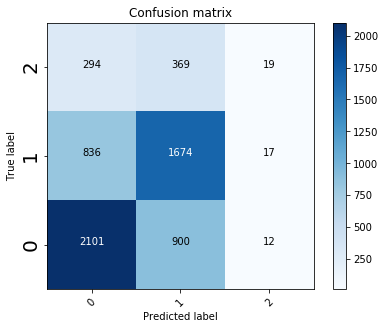

In [8]:
cm = confusion_matrix(y_test, pred, labels=[0, 1, 2])
plot_confusion_matrix(cm, classes=[0, 1, 2])

Demostrate feature Importance for each of the three class

In [13]:
zeroClass = []
oneClass = []
twoClass = []
listClass = [zeroClass, oneClass, twoClass]
for idx in range(clf.coef_.shape[0]):
    for position, each in enumerate(clf.coef_[idx]):
        listClass[idx].append((each,position))

In [14]:
for idx in range(len(listClass)):
    if idx == 2:
        listClass[idx] = sorted(listClass[idx],reverse=True)
    else:
        listClass[idx] = sorted(listClass[idx],reverse=False)
featureNameList = tfidf_vectorizer.get_feature_names()
print('Class False')
for each in listClass[0][:30]:
    print(featureNameList[each[1]])
print('#############')
print('Class Partial True')
for each in listClass[1][485:515]: 
    if each[1] < 1000:
        print(featureNameList[each[1]])  
    else:
        print('feature number %d is not in the list' %each[1])
print('#############') 
print('Class True')
for each in listClass[2][-30:]:
    print(featureNameList[each[1]])

Class False
data
race
deport
bush
spend
nomin
think
contribut
sponsor
2013
pay
center
fair
pictur
campaign
reform
fund
2007
opportun
amend
paid
district
ye
return
trend
busi
militari
differ
rate
prohibit
#############
Class Partial True
special
begin
consist
arm
open
commun
quickli
taxpay
la
diseas
advis
east
extend
cancer
adopt
sen
grant
offic
self
sanction
mail
000
13
sens
noth
director
feature number 1102 is not in the list
feature number 1073 is not in the list
regist
50
#############
Class True
ban
threat
putin
40
expans
job
florida
individu
labor
applaus
titl
design
white hous
presid trump
author
organ
attack
forc
fake
obama
russia
facebook
quot
2019
evid
revenu
claim
news
fact
studi
